## This jupyter notebook contains deep dive in the data provided by AXA to understand the data to find answers of the following perceptions.

In [ ]:
#Necessary package installation

import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tqdm
import cv2
from scipy.spatial import distance
from PIL import Image
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import scipy

### Q1) 1.	First we have a problem in the consistency in the way the motor make and motor model is entered (e.g. Corll instead of Corolla or VW instead of Volkswagen) Can you propose a logic to fix these inconstancies. Note the that there are multiple ways to do it and you will be scored on the percentage of the reduced inconsistencies. 

In [227]:
os.chdir('D:/data_science/axa_assessment')
data = pd.read_csv('D:/data_science/axa_assessment/assessment_data2.csv')
data.columns

Index(['CU_CU_ID', 'GE_GDR_NM', 'CO_CNTY_NM', 'NUM_OF_ADD',
       'CO_NATLY_CNTY_CODE', 'DR_CUSTOMER_AGE', 'PROPERTY_POLICY_COUNT',
       'HEALTH_POLICY_COUNT', 'CASUALTY_POLICY_COUNT', 'DR_MOTOR_POL_ACTIVE',
       'TOTAL_MOTOR_POLICY_COUNT', 'PLC_DTL_VEH_MAKE_CODE',
       'PLC_DTL_VEH_MODEL', 'PLC_DTL_VEH_VERSION', 'MOMA_MOT_MAKE_NM',
       'PLC_DTL_VEH_PRICE_AED', 'make_corrected', 'CO_NATLY_CNTY_CODE_grouped',
       'AED_group', 'nation_group'],
      dtype='object')

In [8]:
#Look in to model names to find out patterns of inconsistency

make = data.MOMA_MOT_MAKE_NM.valuessort_values(ascending=True)
make

TOYOTA              8191
NISSAN  P           2045
FORD                2028
LEXUS RX30          1720
MITSUBISHI          1596
BMW                 1578
HONDA               1478
JEEP                1210
MERCEDES            1178
LAND ROVER          1170
GMC                 1021
CHEVROLETT           919
TOYOTAL              887
HYUND                878
VOLKSWAGEN           835
KIA                  704
AUDI                 646
PORSCHE              590
MAZDA                477
DODGE                420
INFINITI             398
SUZUKI GR            270
NISSAN               269
TOYOTA 15            236
SUBARU               181
VOLVO 940            178
PEUGEOT              173
JAGUAR               169
HARLEY DAVIDSON      166
HYUNDAI              161
                    ... 
LOTUS                  5
FIAT                   5
APRILIA                5
HYS                    4
TESLA                  4
MOTO GUZZI             4
BUICK                  4
ASTON                  4
SYM                    4


#### Now we can built an automated algorithmic solution(manual solution is tidy and time consuming) to remove the inconsistency in entry of vehicle make. We will calculate string distance(levenshteinDistance) between two strings and in case of any inconsistent(wrong) entry, from this distence metric algorithm, it will find the nerest correct vehicle make name. For example in case of Toyotal(wrong spelling of Toyota), it will replace as correct name Toyota. I created an addition column 'make_corrected' and added to the dataset. Now it has 100% accurate solution.

In [ ]:
#Function to calculater string distance
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

#Dictionary of correct makes 
make = data.MOMA_MOT_MAKE_NM.unique()
make=pd.Series(make)
make = make.sort_values(ascending = True)
legitimate_make = ["AJS",
"ALFA ROMEO",
"APRILIA",
"ASTON MARTIN",
"AUDI",
"B Y D",
"BAIC",
"BAJAJ",
"BENTLEY",
"BENZHOU",
"BMW",
"BUELL",
"BUICK",
"CADILLAC",
"CAN-AM",
"CHANGAN",
"CHERY",
"CHEVROLET",
"CHRYSLER",
"CITROEN",
"CMC",
"DAEWOO 1.6",
"DAIHATSU",
"DATSUN",
"DODGE",
"DUCATI",
"ENFIELD",
"FERRARI",
"FIAT",
"FORD",
"GEELY",
"GMC",
"HARLEY DAVIDSON",
"HONDA",
"HUMMER",
"HUSQVARNA",
"HYS",
"HYUNDAI",
"INDIAN",
"INFINITI",
"INFINITY",
"ISUZU ONE ",
"JAGUAR",
"JEEP",
"JONW",
"KAWASAKI",
"KIA",
"KTM",
"LAMBORGHINI",
"LAND ROVER",
"LEXUS",
"LINCOLN",
"LOTUS",
"LUX",
"MASERATI",
"MAZDA",
"MERCEDES",
"MERCURY",
"MG",
"MINI",
"MITSUBISHI",
"MOTO GUZZI",
"MV AGUSTA",
"NISSAN",
"OPEL",
"PANTHER DEVILLE",
"PEUGEOT",
"PIA",
"PLYTH",
"POLARIS SINGSHOT",
"PONTIAC",
"PORSCHE",
"PROTON",
"RENAULT",
"ROLLS ROYCE",
"ROVER",
"SAAB",
"SEAT",
"SKODA",
"SMART",
"SSANGYONG",
"SUBARU",
"SUZUKI",
"SYM",
"TESLA",
"TOYOTA",
"TRIUMPH",
"TVS",
"VESPA",
"VICTORY",
"VOLKSWAGEN",
"VOLVO",
"YAMAHA"
]
#Modify makenames with correct make name
make_courrected = []
for i in tqdm(range(data.shape[0])):
    dist=1000
    for j in legitimate_make:
        #print('comparing with:'+str(j))
        lev_dist = levenshteinDistance(data.MOMA_MOT_MAKE_NM[i], j)
        if lev_dist < dist:
            dist = lev_dist
            make = j
        if data.MOMA_MOT_MAKE_NM[i] == 'ASTON':
            make = 'ASTON MARTIN'   
    make_courrected.append(make)        
make_courrected = pd.Series(make_courrected)
data['make_corrected'] = make_courrected

##### We can check the solution. We have wrong entries at 6th(CHEVROLETT),11th(NISSAN  P) and 108th(Toyotal) observations. Let's see the result after correction.

In [605]:
print(data.iloc[[5,10,107],[14,16]])

      MOMA_MOT_MAKE_NM make_corrected
10688       CHEVROLETT      CHEVROLET
24063        NISSAN  P         NISSAN
23983          TOYOTAL         TOYOTA


#### *Work on Vehicle Model*

###### We have not found any anomly for name of the vehicle model. Some model names are duplicated because of a few of the vehicle make names were invalid.After correction of vehicle names, now there is one to one mapping for model name vs. make name. For example prior to correction model name C30 and S40 were included both under vehicle make VOLVO and VOLVO940. After correction only make VOLVO is there in the dataset and C30 and S40 models are only under vehicle make VOLVO. Let's check few instances.

In [608]:
print(data.iloc[[32378,12455,21399,23222],[12,14,16]])

      PLC_DTL_VEH_MODEL MOMA_MOT_MAKE_NM make_corrected
23146               C30            VOLVO          VOLVO
18758               C30       VOLVO 940           VOLVO
16407               S40       VOLVO 940           VOLVO
7436                S40            VOLVO          VOLVO


## We are done

### Q2) We believe that male policy holders drive more expensive cars than females. Can you confirm/refute this with a sound statistical test?

## - Solution

#### We will see distribution(kernel density plot), mean values of PLC_DTL_VEH_PRICE_AED for male and female groups. It will give us an insight about difference. Then to test our hypothesis with statistical significance, we will conduct a two sample t-test and can make the decision.

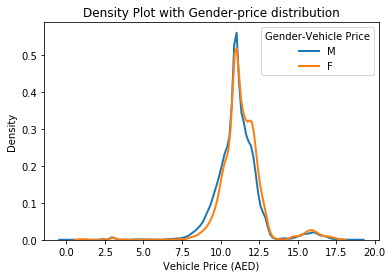

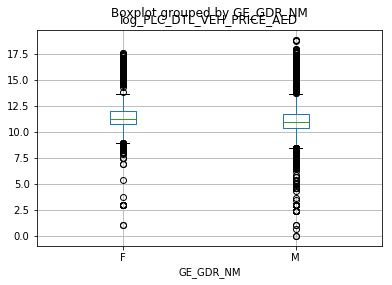

In [65]:
# Distribution of vehicle price for male and female
import seaborn as sns
data['log_PLC_DTL_VEH_PRICE_AED'] = np.log1p(data['PLC_DTL_VEH_PRICE_AED'])
gender = ['M', 'F']

# Iterate through the five airlines
for g in gender:
    # Subset to the airline
    subset = data[data['GE_GDR_NM'] == g]
    
    # Draw the density plot
    sns.distplot(subset['log_PLC_DTL_VEH_PRICE_AED'], hist = False, kde = True,
                 kde_kws = {'linewidth': 2},
                 label = g)
    
# Plot formatting
plt.legend(prop={'size': 10}, title = 'Gender-Vehicle Price')
plt.title('Density Plot with Gender-price distribution')
plt.xlabel('Vehicle Price (AED)')
plt.ylabel('Density')
data.loc[data['GE_GDR_NM']!='UNK',['log_PLC_DTL_VEH_PRICE_AED', 'GE_GDR_NM']].boxplot(column='log_PLC_DTL_VEH_PRICE_AED', by='GE_GDR_NM')

In [609]:
data.loc[data['GE_GDR_NM']!='UNK',['PLC_DTL_VEH_PRICE_AED', 'GE_GDR_NM']].groupby(['GE_GDR_NM']).mean()

,PLC_DTL_VEH_PRICE_AED
GE_GDR_NM,
F,562400.140341
M,483127.661216
UNK,NaN


#### From the distribution and group mean value we can see that rather on an average female customers drive more expensive cars than males. However we need to check whether this difference is statistically significant or not through two sample t-test to reject/accept the null hypotheisis (there is no difference in vehicle price for male policy holders and females policy holders).

In [26]:
#statistical test whether male policy holders drive more expensive cars than females

male = data.loc[data['GE_GDR_NM'] == 'M',] 
female = data.loc[data['GE_GDR_NM'] == 'F',]
twosample_results = scipy.stats.ttest_ind(male['PLC_DTL_VEH_PRICE_AED'] , female['PLC_DTL_VEH_PRICE_AED'])

matrix_twosample = [
    ['', 'Test Statistic', 'p-value'],
    ['Sample Data', twosample_results[0], twosample_results[1]]
]

twosample_table = FF.create_table(matrix_twosample, index=True)
twosample_results

C:\Users\Sourish\Anaconda3\lib\site-packages\plotly\tools.py:1506: UserWarning:

plotly.tools.FigureFactory.create_table is deprecated. Use plotly.figure_factory.create_table



Ttest_indResult(statistic=-1.2457006214703872, pvalue=0.21289176203061838)

#### As the pvalue(0.21289176203061838) is more than 0.05, we can't reject our null hypotheis. So we can conclude that there is no difference in vehicle price for male policy holders and females policy holders, which is statistically significant. 

### Q3) 3.	We believe that certain nationality types are more prone to buy certain type of cars, can you confirm/refute?

- ### Solution

#### We can get the vehicle type from PLC_DTL_VEH_VERSION. There are many features we can extract from PLC_DTL_VEH_VERSION. However for sake of time and simplicity we will do feature engineering for engine size(engine_size_cc) and from this we will make a derived proxy variable- Vehicle_size. With these two variables, describing vehile type, we will see descriptive stats(eg cross tabs,group means etc.) and distribution plots to explore whether certain nationality types are more prone to buy certain type of cars. Then we will conduct statistical tests(One way Annova for engine size  and pearson chi square test of independence for Vehicle_size), to have a conclusion. 

In [39]:
data['CO_NATLY_CNTY_CODE'].value_counts()

0      18392
56      4197
1       2066
68      2035
78      1043
125     1028
36       508
87       476
5        334
45       307
50       293
88       204
105      194
30       180
117      174
133      156
92       125
73       121
41       113
15       106
32        82
57        80
64        76
3         75
123       75
135       75
54        74
53        70
70        57
109       57
       ...  
131        2
52         2
108        2
63         2
75         2
43         2
65         1
128        1
2          1
33         1
97         1
129        1
34         1
127        1
100        1
37         1
7          1
39         1
74         1
12         1
48         1
20         1
85         1
119        1
89         1
121        1
91         1
28         1
126        1
110        1
Name: CO_NATLY_CNTY_CODE, Length: 137, dtype: int64

In [288]:
#There are too many nationality code, let's group the nationality codes having frequency less than 100 and make it other(1000)
import tqdm
from tqdm import tqdm,tqdm_pandas
nation = data_original.CO_NATLY_CNTY_CODE.unique()
#nation_group = nation[data_original.CO_NATLY_CNTY_CODE.value_counts() < 100]
CO_NATLY_CNTY_CODE_grouped = pd.Series([])
for i in tqdm(range(data.shape[0])):
    if data_original.CO_NATLY_CNTY_CODE[i] in nation_group:
        CO_NATLY_CNTY_CODE_grouped[i] = 1000
    else:
        CO_NATLY_CNTY_CODE_grouped[i] = data_original.CO_NATLY_CNTY_CODE[i]
data['CO_NATLY_CNTY_CODE_grouped'] = CO_NATLY_CNTY_CODE_grouped         

100%|███████████████████████████████████████████████████████████████████████████| 33863/33863 [00:44<00:00, 767.93it/s]


In [610]:
#Now we have few classes for nationality

data.CO_NATLY_CNTY_CODE_grouped.value_counts()

0       18392
56       4197
1000     2719
1        2066
68       2035
78       1043
125      1028
36        508
87        476
5         334
45        307
105       194
117       174
133       156
73        121
41        113
Name: CO_NATLY_CNTY_CODE_grouped, dtype: int64

In [293]:
data['CO_NATLY_CNTY_CODE_grouped'].value_counts() 
data.to_csv('data_make_nationality_corrected_price_nat_gr.csv')

In [82]:
#Explore the field PLC_DTL_VEH_VERSION  
data.PLC_DTL_VEH_VERSION.value_counts()

3.5L                              5274
2.0L                              1443
1.6L                              1286
2.4L                              1270
3.0L                              1041
1.8L                              1000
4.0L                               797
2.5L                               670
5.7L                               583
3.6L                               489
SALOON                             452
1.5L                               427
2.4L SEDAN                         412
1.3L SEDAN                         326
5.6L                               321
4.6L                               317
4.0L 8 SEATER                      292
4.6L GXR                           290
3.5L LWB                           288
4.0L 7 SEATER                      280
5.0L                               272
3.8L LWB                           245
3.7L                               224
5.3L 5 SEATER                      221
2.7L 7 SEATER                      214
3.2L                     

In [303]:
#There are too many- We need to group it applying some regex logic to get engine size Vehicle type

#To filter out for numerical values(there is slight approximation)
import re
temp = []
for i in tqdm(range(data.shape[0])):
    if data.PLC_DTL_VEH_VERSION[i][0].isdigit():
        temp.append(data.PLC_DTL_VEH_VERSION[i])
    else:
        temp.append('not_sure')

#to extract size portion from string(approx 98% correct)
engine_size = []
for i in tqdm(range(len(temp))):
    if temp[i] != 'not_sure':
        l = len(temp[i])
        if l > 3:
            size = temp[i][0:4]
        else:
            size = temp[i]
        engine_size.append(size)
    else: 
        engine_size.append('not_sure')

#To convert in numeric format(approx 98% correct)        
engine_size_cc = []
for i in tqdm(range(len(temp))):
    if temp[i] != 'not_sure':
        if (re.search('L', engine_size[i])!=None): 
            size = temp[i][0:3]
            l = (re.findall('\d+', size))
            l ='.'.join(l)
            size = float(l) * 1000
        else:
            size = engine_size[i]
            l = (re.findall('\d+', engine_size[i]))
            l = ''.join(l)
            size = float(l)
        engine_size_cc.append(size)
    else: 
        engine_size_cc.append('not_sure')  
        
engine_size_cc = pd.Series(engine_size_cc)
data['engine_size_cc'] = engine_size_cc

100%|████████████████████████████████████████████████████████████████████████| 33863/33863 [00:00<00:00, 161664.59it/s]


#### We need to do some outlier treatment, as there might be few anomalies, during creation engine_size_cc. From reseach we found out that the Most Powerful Car: Koenigsegg HP: 1341(approx 22500 cc). So we can fix 25000 cc as our upper bound. 

In [323]:
#There might be some outlier- so let's cap and floor for outlier(Most Powerful Car: Koenigsegg HP: 1341)
for i in tqdm(range(data.shape[0])):
    if data['engine_size_cc'][i] != 'not_sure':
        if data['engine_size_cc'][i] <100:
            data['engine_size_cc'][i] = 100
        elif data['engine_size_cc'][i] >= 25000:
            data['engine_size_cc'][i] = 25000
    else:
        data['engine_size_cc'][i] = data['engine_size_cc'][i]         

100%|█████████████████████████████████████████████████████████████████████████| 33863/33863 [00:03<00:00, 10039.78it/s]


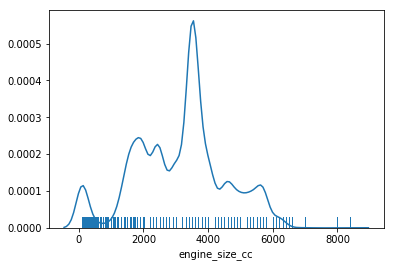

In [328]:
#Let's see the distribution and impute not_sure with sutable value
sns.distplot(data['engine_size_cc'][data['engine_size_cc'] != 'not_sure'], hist = False, kde = True,rug=False,
                 kde_kws = {'linewidth': 1.5})
data['engine_size_cc'][data['engine_size_cc'] == 'not_sure']=data['engine_size_cc'][data['engine_size_cc'] != 'not_sure']
data['engine_size_cc'][data['engine_size_cc'] == 'not_sure']=np.mean(data['engine_size_cc'][data['engine_size_cc'] != 'not_sure'])

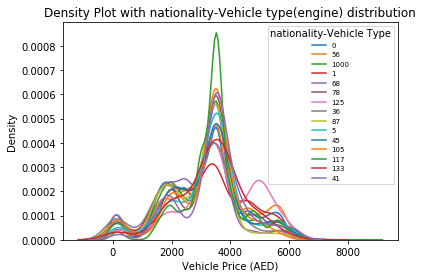

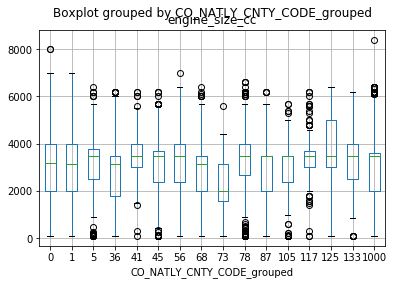

In [336]:
#Distribution of vehicle types in terms of engine size for nationality types
import seaborn as sns
data['engine_size_cc'] = pd.to_numeric(data['engine_size_cc'], errors='coerce')
nationality = [0,  56,   1000,   1,   68,    78,   125,   36,   87,
         5,45,  105,  117, 133,  41]

# Iterate through the five airlines
for n in nationality:
    # Subset to the airline
    subset = data[data['CO_NATLY_CNTY_CODE_grouped'] == n]
    
    # Draw the density plot
    sns.distplot(subset['engine_size_cc'], hist = False, kde = True,
                 kde_kws = {'linewidth': 1.5},
                 label = n)
    
# Plot formatting
plt.legend(prop={'size': 7}, title = 'nationality-Vehicle Type')
plt.title('Density Plot with nationality-Vehicle type(engine) distribution')
plt.xlabel('Vehicle Price (AED)')
plt.ylabel('Density')
data[['engine_size_cc', 'CO_NATLY_CNTY_CODE_grouped']].groupby(['CO_NATLY_CNTY_CODE_grouped']).mean()
data.boxplot('engine_size_cc', by = 'CO_NATLY_CNTY_CODE_grouped')

In [337]:
data[['engine_size_cc', 'CO_NATLY_CNTY_CODE_grouped']].groupby(['CO_NATLY_CNTY_CODE_grouped']).mean()

,engine_size_cc
CO_NATLY_CNTY_CODE_grouped,
0,3123.715427
1,3071.953689
5,3250.974472
36,2819.342846
41,3422.829929
45,3116.050758
56,3325.903446
68,2823.233517
73,2184.534643


#### From the descriptive stats and distribution plots we can see there are some differences for type of cars(engine size). However to corroborate this we will do one way Annova test and will see the F and p-value.

In [613]:
#There are some differences in choosing vehicle types in terms of size of engine- Let's see whether this is statistically significant

#One way Annova test to test difference in mean values for more than 2 groups
import statsmodels.api as sm
from statsmodels.formula.api import ols
mod = ols('engine_size_cc ~ CO_NATLY_CNTY_CODE_grouped', data.loc[data['CO_NATLY_CNTY_CODE_grouped']!=0,]).fit()
aov_tab = sm.stats.anova_lm(mod,typ=2)
print(aov_tab)
print(aov_tab['sum_sq'][0]/(aov_tab['sum_sq'][0]+aov_tab['sum_sq'][1]))


                                  sum_sq       df         F    PR(>F)
CO_NATLY_CNTY_CODE_grouped  1.189547e+07      1.0  6.778744  0.009234
Residual                    2.714529e+10  15469.0       NaN       NaN
0.00043802281479721276


#### As p-value(0.009234) is less than critical p-value(0.05) for 95% statistical confidence level and F-statistics is more than critical value for this df(degree of freedom), we can reject our null hypothesis. So we can say that the differences for type of cars(w.r.t. engine cc)across nationalities is statistically significant.

#### We can extract another feature- size of vehicle, regarding vehicle type and can test

In [345]:
#Let's see for size of vehicle

data['Vehicle_size'] = pd.qcut(data['engine_size_cc'], 3, labels=False)
for i in tqdm(range(data.shape[0])):
    if data['Vehicle_size'].iloc[i]==0:
        group[i]='small'
    elif data['Vehicle_size'].iloc[i]==1:
        group[i]='medium'
    else:
        group[i]='large'
          
data['Vehicle_size'] = group
print(data['Vehicle_size'].value_counts())
data[['engine_size_cc', 'Vehicle_size']].groupby(['Vehicle_size']).mean()

100%|█████████████████████████████████████████████████████████████████████████| 33863/33863 [00:02<00:00, 14761.95it/s]


medium    11736
small     11589
large     10538
Name: Vehicle_size, dtype: int64


,engine_size_cc
Vehicle_size,
large,4602.495730
medium,3296.942523
small,1650.885409


Vehicle_size                   large    medium     small
CO_NATLY_CNTY_CODE_grouped                              
1                           0.041626  0.039623  0.052291
5                           0.008015  0.008015  0.005559
36                          0.006916  0.012410  0.013509
41                          0.002909  0.002909  0.001487
45                          0.006528  0.006528  0.006787
56                          0.098636  0.092108  0.080538
68                          0.022817  0.055588  0.053132
73                          0.000582  0.002456  0.004783
78                          0.023916  0.027018  0.016482
87                          0.005171  0.014608  0.010988
105                         0.003103  0.005947  0.003490
117                         0.003878  0.005494  0.001874
125                         0.028117  0.025726  0.012604
133                         0.004137  0.003361  0.002585
1000                        0.046280  0.071101  0.058367


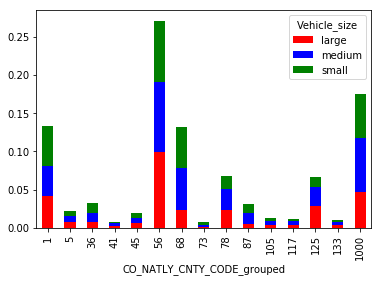

In [349]:
#Let's see the distribution of vehicle size wrt to different nationality
temp = data.loc[data['CO_NATLY_CNTY_CODE_grouped']!=0,]
temp3 = pd.crosstab(temp['CO_NATLY_CNTY_CODE_grouped'], data['Vehicle_size'], normalize=True)
temp3.plot(kind='bar', stacked=True, color=['red','blue','green'], grid=False)
print(temp3)

In [350]:
pd.crosstab(temp['CO_NATLY_CNTY_CODE_grouped'], temp['Vehicle_size'], margins=True)

Vehicle_size,large,medium,small,All
CO_NATLY_CNTY_CODE_grouped,,,,
1,644,613,809,2066
5,124,124,86,334
36,107,192,209,508
41,45,45,23,113
45,101,101,105,307
56,1526,1425,1246,4197
68,353,860,822,2035
73,9,38,74,121
78,370,418,255,1043


In [612]:
#There is difference in dist.Let's check statistical significance

#chi-square test for independence
cross_tab = pd.crosstab(temp['CO_NATLY_CNTY_CODE_grouped'], temp['Vehicle_size'], margins=True)
observed = cross_tab.ix[0:15,0:3]
print(observed)
expected =  np.outer(cross_tab["All"][0:15],
                     cross_tab.ix["All"][0:3]) / 15471

expected = pd.DataFrame(expected)
expected.columns = ['large','medium','small']
expected.index = [1,5,36,41,45,56,68,73,78,87,105,117,125,133,1000]
print(expected)
from scipy.stats import chi2
chi_squared_stat  = (((observed-expected)**2)/expected).sum().sum()
print('chi_squared_stat')
print(chi_squared_stat)
crit = chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 30)   # df = (row-1)*(column-1)
print("Critical value")
print(crit)

p_value = 1 - chi2.cdf(x=chi_squared_stat,  # Find the p-value
                             df=30)
print("P value")
print(p_value)

C:\Users\Sourish\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



Vehicle_size                large  medium  small
CO_NATLY_CNTY_CODE_grouped                      
1                             644     613    809
5                             124     124     86
36                            107     192    209
41                             45      45     23
45                            101     101    105
56                           1526    1425   1246
68                            353     860    822
73                              9      38     74
78                            370     418    255
87                             80     226    170
105                            48      92     54
117                            60      85     29
125                           435     398    195
133                            64      52     40
1000                          716    1100    903


C:\Users\Sourish\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



            large       medium        small
1      625.235085   770.393252   670.371663
5      101.078663   124.545666   108.375671
36     153.736410   189.428738   164.834852
41      34.197272    42.136707    36.666020
45      92.907634   114.477603    99.614763
56    1270.141167  1565.024433  1361.834400
68     615.853532   758.833624   660.312843
73      36.618318    45.119837    39.261845
78     315.643850   388.925538   338.430612
87     144.052227   177.496219   154.451555
105     58.710361    72.340896    62.948743
117     52.657747    64.883072    56.459182
125    311.104389   383.332170   333.563441
133     47.210394    58.171030    50.618577
1000   822.852951  1013.891216   882.255833
chi_squared_stat
643.0220715649066
Critical value
43.77297182574219
P value
0.0


#### As the test chi_squared_stat(643.0220715649066) is more than Critical value(43.77297182574219) and p value is very close to zero (less than 0.05), we can reject our null hypothesis. So from the two statistical tests(One way Anova for engine size and chi_square test for vehicle size) we can conclude that the differences for type of cars(w.r.t. engine cc)across nationalities is statistically significant. This infers that certain nationality types are more prone to buy certain type of cars.

- #### Other possible Approaches 

###### Off course there are other features related to vehicles like vehicle model names and Vehicle make name. Also in PLC_DTL_VEH_VERSION string there are other features, like no of seats, vehicle category(sedan, hatchback etc.) can be extracted. For sake of time I left analysis basis these feature. Following are some approaches by which we can get more insights about the relationship between vehicle type and nationality group:

 A)	Based original geography of vehicle manufacturer, we can group the vehicle makes(for example Toyota, Nissan, Honda, Suzuki, Mitsubishi etc. as Japanese manufacturers) and so on. With this geography based vehicle make cluster we can explore whether certain nationalities are prone to certain vehicle make clusters.

B)	We can test whether certain nationalities are prone to certain usage category(3rd party use, vehicle for adventure etc.) of vehicles.

C)	From combined group of vehicle makes and model names, we can infer certain nationalities’ choice for category of vehicle(economy, sedan, luxury, sports etc.)
 

### Q4) We believe that certain nationality types are more prone to buy more expensive cars, can you confirm/refute?

- ### Solution

#### We will see distribution(kernel density plot), mean values of PLC_DTL_VEH_PRICE_AED for different nationality groups. It will give us an insight about differences, if any. Then to test our hypothesis with statistical significance, we will conduct an one way Annova test and can make the decision. Also we will create one categorical feature- vehicle price group(AED_group), to explore strength of association wrt nationality groups with chi_square test of independence.

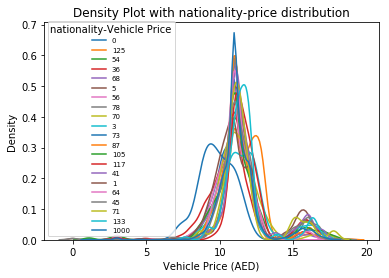

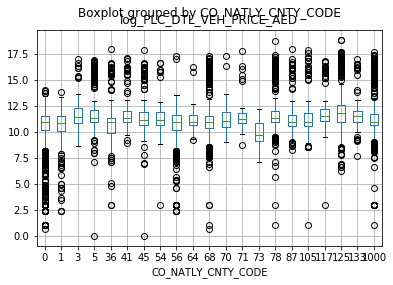

In [64]:
# Distribution of vehicle price for nationality types 
import seaborn as sns
data['log_PLC_DTL_VEH_PRICE_AED'] = np.log1p(data['PLC_DTL_VEH_PRICE_AED'])
nationality = [0,  125,   54,   36,   68,    5,   56,   78,   70,    3,   73,
         87,  105,  117,   41,    1,   64,   45,   71,  133, 1000]

# Iterate through the five airlines
for n in nationality:
    # Subset to the airline
    subset = data[data['CO_NATLY_CNTY_CODE'] == n]
    
    # Draw the density plot
    sns.distplot(subset['log_PLC_DTL_VEH_PRICE_AED'], hist = False, kde = True,
                 kde_kws = {'linewidth': 1.5},
                 label = n)
    
# Plot formatting
plt.legend(prop={'size': 7}, title = 'nationality-Vehicle Price')
plt.title('Density Plot with nationality-price distribution')
plt.xlabel('Vehicle Price (AED)')
plt.ylabel('Density')
data[['PLC_DTL_VEH_PRICE_AED', 'CO_NATLY_CNTY_CODE']].groupby(['CO_NATLY_CNTY_CODE']).mean()
data.boxplot('log_PLC_DTL_VEH_PRICE_AED', by = 'CO_NATLY_CNTY_CODE')

##### From the descriptive stats and distribution plots we can see there are some differences for price cars accross nationalities. However to corroborate this we will do one way Annova test and will see the F and p-value.

In [81]:
#Statistical test for to detect whether certain nationality types are more prone to buy more expensive cars- One way Annova
import statsmodels.api as sm
from statsmodels.formula.api import ols
mod = ols('PLC_DTL_VEH_PRICE_AED ~ CO_NATLY_CNTY_CODE', data).fit()
aov_tab = sm.stats.anova_lm(mod,typ=2)
print(aov_tab)
print(aov_tab['sum_sq'][0]/(aov_tab['sum_sq'][0]+aov_tab['sum_sq'][1]))

                          sum_sq       df        F        PR(>F)
CO_NATLY_CNTY_CODE  6.886862e+14      1.0  133.711  7.223066e-31
Residual            1.744030e+17  33861.0      NaN           NaN
0.003933288326041118


##### As p-value(7.223066e-31) is less than critical p-value(0.05) for 95% statistical confidence level and F-statistics is more than critical value for this df(degree of freedom), we can reject our null hypothesis. So we can say that the differences in price of vehicles(w.r.t. engine cc)across nationalities is statistically significant. It infers that certain nationality types are more prone to buy more expensive cars.


#### We can also create bands for vehicle price(PLC_DTL_VEH_PRICE_AED) and can test the strength of association with nationality groups.

In [346]:
#Some analysis on Vehicle price category and relationship with nationality

data['AED_group'] = pd.qcut(data['PLC_DTL_VEH_PRICE_AED'], 5, labels=False)
group = pd.Series([])
for i in tqdm(range(data.shape[0])):
    if data['AED_group'][i]==0:
        group[i]='Low'
    elif data['AED_group'][i]==1:
        group[i]='Med'
    elif data['AED_group'][i]==2:
        group[i]='High'
    elif data['AED_group'][i]==3:
        group[i]='VeryHigh' 
    else:
        group[i]='SuperHigh'
out_lier_removed_data['AED_group'] = group        
print(data['AED_group'].value_counts())
data[['PLC_DTL_VEH_PRICE_AED', 'AED_group']].groupby(['AED_group']).mean()

100%|███████████████████████████████████████████████████████████████████████████| 33863/33863 [01:31<00:00, 372.01it/s]


0    6780
4    6773
2    6773
3    6771
1    6766
Name: AED_group, dtype: int64


,PLC_DTL_VEH_PRICE_AED
AED_group,
0,1.325361e+04
1,3.546338e+04
2,5.858742e+04
3,9.735348e+04
4,1.220387e+06


0.0         0.000000
0.1     13717.677594
0.2     24069.452400
0.3     34938.911460
0.4     48998.528100
0.5     58603.740000
0.6     69044.973010
0.7     95513.700000
0.8    136722.525440
0.9    202966.612500
Name: PLC_DTL_VEH_PRICE_AED, dtype: float64
0.900000    2.029666e+05
0.911111    2.150000e+05
0.922222    2.295313e+05
0.933333    2.490000e+05
0.944444    2.800000e+05
0.955556    3.242134e+05
0.966667    3.820548e+05
0.977778    4.714505e+05
0.988889    6.561000e+06
1.000000    1.500000e+08
Name: PLC_DTL_VEH_PRICE_AED, dtype: float64


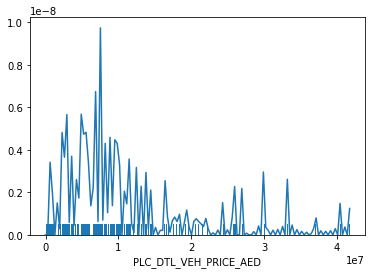

In [257]:
#Distribution of vehicle price and outlier detection
sns.distplot(subset['PLC_DTL_VEH_PRICE_AED'], hist = False, kde = True,rug=True,
                 kde_kws = {'linewidth': 1.5})

0.0         0.000000
0.1     13717.677594
0.2     24069.452400
0.3     34938.911460
0.4     48998.528100
0.5     58603.740000
0.6     69044.973010
0.7     95513.700000
0.8    136722.525440
0.9    202966.612500
Name: PLC_DTL_VEH_PRICE_AED, dtype: float64
0.900000    2.029666e+05
0.911111    2.150000e+05
0.922222    2.295313e+05
0.933333    2.490000e+05
0.944444    2.800000e+05
0.955556    3.242134e+05
0.966667    3.820548e+05
0.977778    4.714505e+05
0.988889    6.561000e+06
1.000000    1.500000e+08
Name: PLC_DTL_VEH_PRICE_AED, dtype: float64


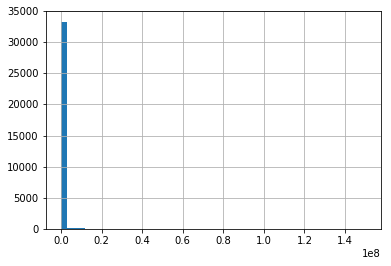

In [261]:
#Outlier detection in vehicle price
print(data["PLC_DTL_VEH_PRICE_AED"].quantile(np.linspace(0,0.9,10)))
print(data["PLC_DTL_VEH_PRICE_AED"].quantile(np.linspace(0.9,1,10)))
data['PLC_DTL_VEH_PRICE_AED'].hist(bins=50)

In [269]:
#Outlier removal from vehicle price and 
out_lier_removed_data = data.loc[data['PLC_DTL_VEH_PRICE_AED'] <= 4.714505e+05]
out_lier_removed_data.shape

(33110, 20)

In [271]:
#Outlier removal from vehicle price and Vehicle Price grouping- Binning
out_lier_removed_data['AED_group'] = pd.qcut(out_lier_removed_data['PLC_DTL_VEH_PRICE_AED'], 5, labels=False)
for i in tqdm(range(out_lier_removed_data.shape[0])):
    if out_lier_removed_data['AED_group'].iloc[i]==0:
        group[i]='Low'
    elif out_lier_removed_data['AED_group'].iloc[i]==1:
        group[i]='Med'
    elif out_lier_removed_data['AED_group'].iloc[i]==2:
        group[i]='High'
    elif out_lier_removed_data['AED_group'].iloc[i]==3:
        group[i]='VeryHigh' 
    else:
        group[i]='SuperHigh'     
out_lier_removed_data['AED_group'].value_counts()
out_lier_removed_data['AED_group'] = group

100%|███████████████████████████████████████████████████████████████████████████| 33110/33110 [00:36<00:00, 898.46it/s]


In [278]:
#Distribution of price category Before and after outlier treatment
print('Before outlier treatment')
print(data[['PLC_DTL_VEH_PRICE_AED', 'AED_group']].groupby(['AED_group']).mean())
print('After outlier treatment')
print(out_lier_removed_data[['PLC_DTL_VEH_PRICE_AED', 'AED_group']].groupby(['AED_group']).mean())

Before outlier treatment
           PLC_DTL_VEH_PRICE_AED
AED_group                       
0                   1.325361e+04
1                   3.546338e+04
2                   5.858742e+04
3                   9.735348e+04
4                   1.220387e+06
After outlier treatment
           PLC_DTL_VEH_PRICE_AED
AED_group                       
High                58587.422216
Low                 13253.614537
Med                 35463.382234
SuperHigh          218246.849976
VeryHigh            97353.483575


#### Let's visualize the relationship between vehicle price group(AED_group) and nationality group(CO_NATLY_CNTY_CODE_grouped)

AED_group                       High       Low       Med  SuperHigh  VeryHigh
CO_NATLY_CNTY_CODE_grouped                                                   
0                           0.100050  0.121371  0.117178   0.094439  0.110091
1                           0.009391  0.014765  0.015474   0.011842  0.009538
3                           0.000443  0.000325  0.000236   0.001004  0.000207
5                           0.002185  0.000561  0.001417   0.003160  0.002540
36                          0.003248  0.004252  0.002835   0.002303  0.002362
41                          0.000975  0.000148  0.000236   0.001004  0.000975
45                          0.001860  0.000856  0.001860   0.002422  0.002067
54                          0.000502  0.000354  0.000266   0.000591  0.000472
56                          0.024953  0.028438  0.024688   0.024038  0.021823
64                          0.000709  0.000295  0.000354   0.000443  0.000443
68                          0.014736  0.011133  0.010720   0.010

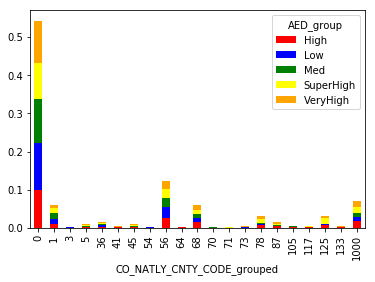

In [285]:
#Nationality wise distribution for different price category cars excluding countries unknown(UNK)
temp3 = pd.crosstab(data['CO_NATLY_CNTY_CODE_grouped'], data['AED_group'], normalize=True)
temp3.plot(kind='bar', stacked=True, color=['red','blue','green','yellow','orange'], grid=False)
print(temp3)

AED_group                       High       Low       Med  SuperHigh  VeryHigh
CO_NATLY_CNTY_CODE_grouped                                                   
1                           0.020555  0.032319  0.033870   0.025919  0.020878
5                           0.004783  0.001228  0.003103   0.006916  0.005559
36                          0.007110  0.009308  0.006205   0.005042  0.005171
41                          0.002133  0.000323  0.000517   0.002198  0.002133
45                          0.004072  0.001874  0.004072   0.005300  0.004525
56                          0.054618  0.062245  0.054037   0.052615  0.047767
68                          0.032254  0.024368  0.023463   0.021977  0.029475
73                          0.001099  0.004460  0.001293   0.000194  0.000776
78                          0.015190  0.003814  0.010213   0.019585  0.018615
87                          0.008791  0.003814  0.005300   0.006334  0.006528
105                         0.003814  0.002198  0.001616   0.003

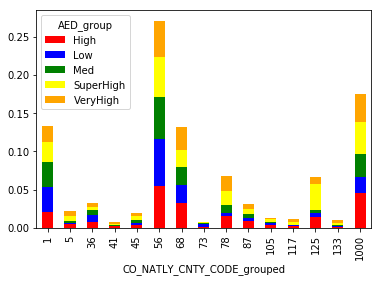

In [294]:
#Nationality wise distribution for different price category cars excluding countries unknown(UNK)
temp = data.loc[data['CO_NATLY_CNTY_CODE_grouped']!=0,]
temp3 = pd.crosstab(temp['CO_NATLY_CNTY_CODE_grouped'], temp['AED_group'], normalize=True)
temp3.plot(kind='bar', stacked=True, color=['red','blue','green','yellow','orange'], grid=False)
print(temp3)

In [296]:
#Significant difference in distribution, whether statistically significant
cross_tab = pd.crosstab(temp['CO_NATLY_CNTY_CODE_grouped'], temp['AED_group'], margins=True)
cross_tab 

AED_group,High,Low,Med,SuperHigh,VeryHigh,All
CO_NATLY_CNTY_CODE_grouped,,,,,,
1,318,500,524,401,323,2066
5,74,19,48,107,86,334
36,110,144,96,78,80,508
41,33,5,8,34,33,113
45,63,29,63,82,70,307
56,845,963,836,814,739,4197
68,499,377,363,340,456,2035
73,17,69,20,3,12,121
78,235,59,158,303,288,1043


#### Significant difference in distribution. However We need to test whether the relationship is statistically significant. We will do a pearson chi-square test for independence for this.

In [371]:
#chi-square test for independence
cross_tab = pd.crosstab(temp['CO_NATLY_CNTY_CODE_grouped'], temp['AED_group'], margins=True)
observed = cross_tab.ix[0:15,0:5]
print(observed)
observed = np.array(observed)
chi2_stat, p_val, dof, ex = chi2_contingency(observed)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)
print("\n")
print("===Contingency Table===")
print(ex)

C:\Users\Sourish\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



AED_group                     0    1    2    3    4
CO_NATLY_CNTY_CODE_grouped                         
1                           500  524  318  323  401
5                            19   48   74   86  107
36                          144   96  110   80   78
41                            5    8   33   33   34
45                           29   63   63   70   82
56                          963  836  845  739  814
68                          377  363  499  456  340
73                           69   20   17   12    3
78                           59  158  235  288  303
87                           59   82  136  101   98
105                          34   25   59   26   50
117                           4   10   44   47   69
125                          67   77  225  146  513
133                           8   20   24   52   52
1000                        333  468  703  584  631
===Chi2 Stat===
1457.0983206848875


===Degrees of Freedom===
56


===P-Value===
7.259443840486662e-268


===Conting

#### As the test chi_squared_stat(1457.0983206848875) is more than Critical value and p value(7.259443840486662e-268) is very close to zero (less than 0.05), we can reject our null hypothesis. So from the two statistical tests(One way Anova for PLC_DTL_VEH_PRICE_AED and chi_square test for price_group(AED_group)), we can conclude that the differences in price of vehicles across nationalities is statistically significant. So we conclude that certain nationality types are more prone to buy more expensive cars.

### 5) Segmentation of customers and insights on some specific customer segments

- ### *Solution*

#### Kmeans clustering tecqnique is the most popular unsupervised customer segmentation tecqnique in business and at the last we will provide few illustrative insights on some specific customer segments.  

In [416]:
#Kmeans cluster approach
data.columns
kmean_data_num = data[['NUM_OF_ADD','DR_CUSTOMER_AGE','PROPERTY_POLICY_COUNT','HEALTH_POLICY_COUNT', 'CASUALTY_POLICY_COUNT','TOTAL_MOTOR_POLICY_COUNT','PLC_DTL_VEH_PRICE_AED','engine_size_cc']]

#Handling Categorical Variables
data_gender = pd.get_dummies(data['GE_GDR_NM'])
data_POL_ACTIVE = pd.get_dummies(data['DR_MOTOR_POL_ACTIVE'])
data_Vehicle_size = pd.get_dummies(data['Vehicle_size'])
data_contry_issue = pd.get_dummies(data['CO_CNTY_NM'])
kmeans_data = pd.concat([kmean_data_num,data_gender,data_POL_ACTIVE,data_Vehicle_size,data_contry_issue], axis=1)
kmeans_data.columns

Index(['NUM_OF_ADD', 'DR_CUSTOMER_AGE', 'PROPERTY_POLICY_COUNT',
       'HEALTH_POLICY_COUNT', 'CASUALTY_POLICY_COUNT',
       'TOTAL_MOTOR_POLICY_COUNT', 'PLC_DTL_VEH_PRICE_AED', 'engine_size_cc',
       'F', 'M', 'UNK', 'N', 'Y', 'large', 'medium', 'small', 'Bahrain',
       'Oman', 'Qatar', 'UNKNOWN', 'UNKOWN', 'United Arab Emirates'],
      dtype='object')

#### It is recommended to normalize the data before clustering. We have done MinMax nomalization(linear transformation of x to (x-min)/(max-min))

In [417]:
#Data preprocessing before clustering- normalize the data
from sklearn import preprocessing

x = kmeans_data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x = min_max_scaler.fit_transform(x)
kmeans_data = pd.DataFrame(x)
kmeans_data.columns = ['NUM_OF_ADD', 'DR_CUSTOMER_AGE', 'PROPERTY_POLICY_COUNT',
       'HEALTH_POLICY_COUNT', 'CASUALTY_POLICY_COUNT',
       'TOTAL_MOTOR_POLICY_COUNT', 'PLC_DTL_VEH_PRICE_AED', 'engine_size_cc',
       'F', 'M', 'UNK', 'N', 'Y', 'large', 'medium', 'small', 'Bahrain',
       'Oman', 'Qatar', 'UNKNOWN', 'UNKOWN', 'United Arab Emirates']
kmeans_data.head(2)

,NUM_OF_ADD,DR_CUSTOMER_AGE,PROPERTY_POLICY_COUNT,HEALTH_POLICY_COUNT,CASUALTY_POLICY_COUNT,TOTAL_MOTOR_POLICY_COUNT,PLC_DTL_VEH_PRICE_AED,engine_size_cc,F,M,...,Y,large,medium,small,Bahrain,Oman,Qatar,UNKNOWN,UNKOWN,United Arab Emirates
0,0.00,0.452961,0.0,0.0,0.0,0.031250,0.003363,0.590361,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.25,0.178165,0.0,0.0,0.0,0.041667,0.001100,0.734940,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### We will try to find out optimal nos of clusters from a range of options, minimizing cdist(The standardized Euclidean distance between two n-vectors)

In [389]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
clusters=range(4,10)
meandist=[]

# loop through each cluster and fit the model to the train set
# generate the predicted cluster assingment and append the mean distance my taking the sum divided by the shape
for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(kmeans_data)
    clusassign=model.predict(kmeans_data)
    meandist.append(sum(np.min(cdist(kmeans_data, model.cluster_centers_, 'euclidean'), axis=1))
    / kmeans_data.shape[0])

#### Elbow method is a method to determine the number of clusters

Text(0.5,1,'Selecting k with the Elbow Method')

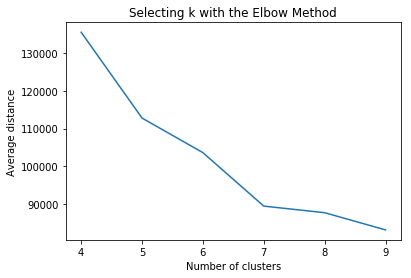

In [391]:
#Plot average distance from observations from the cluster centroid
#to use the Elbow Method to identify number of clusters to choose

plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method') # pick the fewest number of clusters that reduces the average distance

#From the elbow plot we choose no of cluster as 7
model3=KMeans(n_clusters=7)
model3.fit(kmeans_data) # has cluster assingments based on using 3 clusters
clusassign=model3.predict(kmeans_data)
print(model3.cluster_centers_)

#### Now it's time to get some insights about customer segements from cluster analysis result. 

In [418]:
#Merging cluster assignment data with cluster variables- cluster variables means by cluster

kmeans_data.reset_index(level=0, inplace = True)
clustlist = list(kmeans_data['index'])
lebels = list(model3.labels_)
new_list = dict(zip(clustlist,lebels))
new_list = dict(zip(clustlist,lebels))
new_clust = pd.DataFrame.from_dict(new_list, orient = 'index')
new_clust.columns = ['cluster']
new_clust.reset_index(level=0, inplace = True)
merged_kmeans = pd.merge(kmeans_data,new_clust,on='index')
merged_kmeans.head(5)

,index,NUM_OF_ADD,DR_CUSTOMER_AGE,PROPERTY_POLICY_COUNT,HEALTH_POLICY_COUNT,CASUALTY_POLICY_COUNT,TOTAL_MOTOR_POLICY_COUNT,PLC_DTL_VEH_PRICE_AED,engine_size_cc,F,...,large,medium,small,Bahrain,Oman,Qatar,UNKNOWN,UNKOWN,United Arab Emirates,cluster
0,0,0.00,0.452961,0.0,0.0,0.0,0.031250,0.003363,0.590361,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4
1,1,0.25,0.178165,0.0,0.0,0.0,0.041667,0.001100,0.734940,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4
2,2,0.00,0.440027,0.0,0.0,0.0,0.000000,0.003451,0.590361,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,3,0.00,0.266610,0.0,0.0,0.0,0.000000,0.000968,0.469880,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,4,0.05,0.214060,0.0,0.0,0.0,0.031250,0.045258,0.433735,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4


#### Variable means of respective clusters will provide features of each cluster/customer segment.

In [419]:
#Variable Means of respective clusters- These mean values are nomalised between 0 and 1
clust_grp = merged_kmeans.groupby('cluster').mean()
print('clustering variable means by cluster')
print(clust_grp)

clustering variable means by cluster
                index  NUM_OF_ADD  DR_CUSTOMER_AGE  PROPERTY_POLICY_COUNT  \
cluster                                                                     
0         5308.665073    0.001921         0.318963               0.000334   
1        14325.188129    0.020253         0.300450               0.001157   
2        28069.428330    0.001115         0.312272               0.000000   
3        17721.097702    0.010016         0.323377               0.000915   
4         5207.380419    0.044386         0.326392               0.005686   
5        28092.746799    0.034645         0.315176               0.003350   
6        15508.097821    0.063669         0.301338               0.008876   

         HEALTH_POLICY_COUNT  CASUALTY_POLICY_COUNT  TOTAL_MOTOR_POLICY_COUNT  \
cluster                                                                         
0                   0.000015               0.000937                  0.000937   
1                   0.0004

- ### *Interpretation and customer segmentation:* 

##### The above cluster variables means by cluster is quite insightful and provides key information in terms of customers' choice of policy(e.g.Number of property policy held last 5 years), vehicle(price and type) and demographic information(e.g.Number of addresses customer held in the last 5 years,) about different customer segments(clusters).Following are a few examples of data driven insights from customer segmentation with k-means clustering, which would help business to make targeting and pricing strategy customized to each segment.

a)Customer segment 0 and 4(cluster 0 and 4)choose to drive large car(the mean size of engine corroborates this fact) and for majority of the cases policies are made from Oman and UAE resp.

b) Customers in segment 4 and 6 are generally wealthy customers with highest and second highest PLC_DTL_VEH_PRICE_AED score(0.005573 and 0.002128 resp) and highest and second highest Number of addresses score(0.044386 and 0.063669 resp).Business can tweak the premium pricing, as these customers are probably less price sensitive.

c) Customer segment 6 have the most valuable customers for the business having highest scores for HEALTH_POLICY_COUNT(0.003524),PROPERTY_POLICY_COUNT( 0.008876) and CASUALTY_POLICY_COUNT(0.011433) and TOTAL_MOTOR_POLICY_COUNT(0.019957). They are relatively younger customers(least score for age) with significant Female population and 100% policies are made from United Arab Emirates.

There are many more interesting facts hidden in the above analysis and with thorough study business can decipher many more intriguing patterns amongst these segments.

### Q7) predicting someone’s nationality using the given attributes(A machine learning based predictive modeling approach)

- #### Few assumption,limitations, data selection strategy and evaluation metric before start of predictive modelling

a) As the original CO_NATLY_CNTY_CODE has 137 classes, with these limited data(33863 data points),model won't be stable. So We will use 'CO_NATLY_CNTY_CODE_grouped'(grouped all the country code having < 100 frequency and named it as 1000) as our target variable and now have 16 classes.

b) We will use 90% data for building model(development and cross-validation) and 10% for validation(evaluation purpose).

c) We will use most of the given attributes(except for variables having too many categories). Also we will use the variables we derived from feature engineering(engine_size_cc, Vehicle_size and AED_group).

d)With this tiny data for too many classes(16 classes), the model won't be much stable and robust.However we can give it a try.

In [586]:
#Data preparation
data_model = data
cust = data_model[['CU_CU_ID']]
print(data_model.shape)
print(data_model.CO_NATLY_CNTY_CODE_grouped.value_counts())

(33863, 22)
0       18392
56       4197
1000     2719
1        2066
68       2035
78       1043
125      1028
36        508
87        476
5         334
45        307
105       194
117       174
133       156
73        121
41        113
Name: CO_NATLY_CNTY_CODE_grouped, dtype: int64


In [587]:
data.columns
data_model = data_model[['NUM_OF_ADD','DR_CUSTOMER_AGE','PROPERTY_POLICY_COUNT','HEALTH_POLICY_COUNT', 'CASUALTY_POLICY_COUNT','TOTAL_MOTOR_POLICY_COUNT','PLC_DTL_VEH_PRICE_AED','engine_size_cc',
                      'GE_GDR_NM','DR_MOTOR_POL_ACTIVE','Vehicle_size','AED_group','CO_CNTY_NM','CO_NATLY_CNTY_CODE_grouped']]
data_model['GE_GDR_NM'] = data_model['GE_GDR_NM'].astype('object')
#Handling Categorical Variables-converting to numerical LabelEncoding approach
lbl=LabelEncoder()
for i in data_model.columns:
    if data_model[i].dtypes == 'object':
        data_model[i]=lbl.fit_transform(data_model[i])

data_model.head(2)

,NUM_OF_ADD,DR_CUSTOMER_AGE,PROPERTY_POLICY_COUNT,HEALTH_POLICY_COUNT,CASUALTY_POLICY_COUNT,TOTAL_MOTOR_POLICY_COUNT,PLC_DTL_VEH_PRICE_AED,engine_size_cc,GE_GDR_NM,DR_MOTOR_POL_ACTIVE,Vehicle_size,AED_group,CO_CNTY_NM,CO_NATLY_CNTY_CODE_grouped
26081,1,53.577033,0,0,0,4,504450.0,5000.0,1,1,0,3,2,1000
24074,6,32.344564,0,0,0,5,165000.0,6200.0,1,1,0,3,4,45


In [588]:
from sklearn import preprocessing

x = data_model.iloc[:,0:13].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x = min_max_scaler.fit_transform(x)
data_model_X = pd.DataFrame(x)
data_model_X.columns = ['NUM_OF_ADD','DR_CUSTOMER_AGE','PROPERTY_POLICY_COUNT','HEALTH_POLICY_COUNT', 'CASUALTY_POLICY_COUNT','TOTAL_MOTOR_POLICY_COUNT','PLC_DTL_VEH_PRICE_AED','engine_size_cc',
                      'GE_GDR_NM','DR_MOTOR_POL_ACTIVE','Vehicle_size','AED_group','CO_CNTY_NM']

#Data seperation for development and validation
from sklearn.cross_validation import train_test_split
train_X,validation_X,train_Y,validation_Y,train_cust,validation_cust = train_test_split(data_model_X,data_model['CO_NATLY_CNTY_CODE_grouped'],cust, test_size = 0.1, random_state = 20)

print(train_X.head(2))
print(train_Y.head(2))

       NUM_OF_ADD  DR_CUSTOMER_AGE  PROPERTY_POLICY_COUNT  \
9450         0.05         0.249070                    0.0   
21566        0.00         0.223982                    0.0   

       HEALTH_POLICY_COUNT  CASUALTY_POLICY_COUNT  TOTAL_MOTOR_POLICY_COUNT  \
9450                   0.0               0.058824                  0.020833   
21566                  0.0               0.000000                  0.000000   

       PLC_DTL_VEH_PRICE_AED  engine_size_cc  GE_GDR_NM  DR_MOTOR_POL_ACTIVE  \
9450                0.002000        0.493976        0.0                  1.0   
21566               0.000302        0.349398        1.0                  0.0   

       Vehicle_size  AED_group  CO_CNTY_NM  
9450            0.0       0.75        1.00  
21566           0.5       0.50        0.25  
28265    125
15665      0
Name: CO_NATLY_CNTY_CODE_grouped, dtype: int64


##### Now the data is scaled between 0 and 1 and model won't be sensitive to magnitude. Now we are ready to build model.This is a multiclassification problem(15 classes).There are many m/c learning techniques- Decision Tree,Random Forest,Boosing techniques(GBM,XGBoost etc.),SVM etc. and the ideal way would be to try each of them and take the best one or stacking(prediction from multiple ). Because of time constaint we will be focussing on XGBoost(extreme gradient boosting), a class of boosting method,as modelling technique.

##### XGBoost is also called regularized Gradient Boosting(an ensemble decision tree based algorithm) and in python it comes as an algorithm under sklearn package. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples. 

##### For building this model, as optimization strategy, we try to minimize multi-class log loss(mlogloss) metric.

In [590]:
#Model Building
import lightgbm as lgb
import xgboost as xgb
from ctypes import *
from sklearn import datasets, metrics, model_selection
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.grid_search import GridSearchCV,RandomizedSearchCV 
from xgboost.sklearn import XGBClassifier
import pickle

xgb_model = XGBClassifier(n_estimators= 500, max_depth = 4, objective= 'multi:softprob',silent = False,tree_method = 'gpu_hist')
eval_set  = [(train_X,train_Y), (validation_X,validation_Y)]

mod = xgb_model.fit(train_X, train_Y,eval_set=eval_set,early_stopping_rounds=15,verbose = 10,
        eval_metric="mlogloss")

[11:08:23] Allocated 0MB on [0] GeForce GTX 1060 with Max-Q Design, 5029MB remaining.
[11:08:23] Allocated 0MB on [0] GeForce GTX 1060 with Max-Q Design, 5027MB remaining.
[11:08:23] Allocated 0MB on [0] GeForce GTX 1060 with Max-Q Design, 5027MB remaining.
[11:08:24] Allocated 3MB on [0] GeForce GTX 1060 with Max-Q Design, 5024MB remaining.
[11:08:24] Allocated 3MB on [0] GeForce GTX 1060 with Max-Q Design, 5016MB remaining.
[11:08:24] Allocated 0MB on [0] GeForce GTX 1060 with Max-Q Design, 5014MB remaining.
[0]	validation_0-mlogloss:2.24825	validation_1-mlogloss:2.25083
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 15 rounds.
[10]	validation_0-mlogloss:1.14028	validation_1-mlogloss:1.14892
[20]	validation_0-mlogloss:0.86837	validation_1-mlogloss:0.881376
[30]	validation_0-mlogloss:0.766935	validation_1-mlogloss:0.784728
[40]	validation_0-mlogloss:0.723436	validation_1-mloglo

###### Now as we built out first cut model, it's time for prediction and measure the accuracy. For this multiclassification problem prediction metric is multiclass accuracy- maximizing accuracy or minimizing misclassification error

In [591]:
pred = mod.predict(validation_X)

#To calculate multiclass accuracy and misclassification error
print('Model accuracy is:{}%'.format(sum(pred==validation_Y)/validation_Y.shape[0]*100)) 
print('Model error rate is:{}%'.format((1-sum(pred==validation_Y)/validation_Y.shape[0])*100))

[11:43:56] Allocated 0MB on [0] GeForce GTX 1060 with Max-Q Design, 5038MB remaining.


C:\Users\Sourish\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Model accuracy is:79.15559492175966%
Model error rate is:20.844405078240335%


###### We got decent accuracy and low error rate. However we can improve the model with hyperparameter tuning from grid serach and will see if we can improve the accuracy. We will try to train the model with varying few key hyperparameters- depth, learning rate,colsample and subsample rate of XGB algorithm and will pick the hyper parameter setting,which will give maximum performance(low neg_log_loss).Offcource there are many more hyperparameters we can play with.  

In [592]:
#Best hyper parameter search

ind_params = {'learning_rate': 0.03, 'n_estimators': 700, 'seed':100,
             'objective': 'multi:softprob'}
ind_params['nthread'] = 4
ind_params['eval_metric'] = 'mlogloss'
xgb_model = xgb.XGBClassifier(ind_params)
clf = GridSearchCV(xgb_model,
                   {'max_depth': [4,5], 'max_depth': [4,5],'subsample': [0.7,0.8], 'colsample_bytree': [0.5,0.6,0.7,0.8],'learning_rate': [0.02,0.03],
                    }, verbose=2,cv=2,scoring='neg_log_loss')
clf.fit(train_X, train_Y)
clf.best_estimator_

Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV] colsample_bytree=0.5, learning_rate=0.02, max_depth=4, subsample=0.7 
[CV]  colsample_bytree=0.5, learning_rate=0.02, max_depth=4, subsample=0.7 -  17.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.0s remaining:    0.0s


[CV] colsample_bytree=0.5, learning_rate=0.02, max_depth=4, subsample=0.7 
[CV]  colsample_bytree=0.5, learning_rate=0.02, max_depth=4, subsample=0.7 -  17.2s
[CV] colsample_bytree=0.5, learning_rate=0.02, max_depth=4, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.02, max_depth=4, subsample=0.8 -  16.7s
[CV] colsample_bytree=0.5, learning_rate=0.02, max_depth=4, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.02, max_depth=4, subsample=0.8 -  16.4s
[CV] colsample_bytree=0.5, learning_rate=0.02, max_depth=5, subsample=0.7 
[CV]  colsample_bytree=0.5, learning_rate=0.02, max_depth=5, subsample=0.7 -  20.0s
[CV] colsample_bytree=0.5, learning_rate=0.02, max_depth=5, subsample=0.7 
[CV]  colsample_bytree=0.5, learning_rate=0.02, max_depth=5, subsample=0.7 -  20.6s
[CV] colsample_bytree=0.5, learning_rate=0.02, max_depth=5, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.02, max_depth=5, subsample=0.8 -  20.0s
[CV] colsample_bytree=0.5, learning_rate=0.02,

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed: 22.4min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

###### As we got the the best hyperparameter combination of XGB, we can train the model again with these hyperparameters(max_depth=5,learning_rate=0.03,subsample=0.8 and colsample_bytree=0.8) and can assess the model performance(accuracy). 

In [594]:
#Model train with best hyperparameters

xgb_model = XGBClassifier(n_estimators= 500, max_depth = 5, learning_rate=0.03,subsample=0.8,colsample_bytree=0.8, objective= 'multi:softprob',silent = False,tree_method = 'gpu_hist')
eval_set  = [(train_X,train_Y), (validation_X,validation_Y)]

mod_bst = xgb_model.fit(train_X, train_Y,eval_set=eval_set,early_stopping_rounds=15,verbose = 10,
        eval_metric="mlogloss")

pred = mod_bst.predict(validation_X)

#To calculate multiclass accuracy and misclassification error
print('Model accuracy is:{}%'.format(sum(pred==validation_Y)/validation_Y.shape[0]*100)) 
print('Model error rate is:{}%'.format((1-sum(pred==validation_Y)/validation_Y.shape[0])*100))

[12:28:55] Allocated 0MB on [0] GeForce GTX 1060 with Max-Q Design, 5030MB remaining.
[12:28:55] Allocated 0MB on [0] GeForce GTX 1060 with Max-Q Design, 5030MB remaining.
[12:28:55] Allocated 0MB on [0] GeForce GTX 1060 with Max-Q Design, 5030MB remaining.
[12:28:56] Allocated 3MB on [0] GeForce GTX 1060 with Max-Q Design, 5029MB remaining.
[12:28:56] Allocated 3MB on [0] GeForce GTX 1060 with Max-Q Design, 5019MB remaining.
[12:28:56] Allocated 0MB on [0] GeForce GTX 1060 with Max-Q Design, 5017MB remaining.
[0]	validation_0-mlogloss:2.62517	validation_1-mlogloss:2.62636
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 15 rounds.
[10]	validation_0-mlogloss:1.86406	validation_1-mlogloss:1.8714
[20]	validation_0-mlogloss:1.51801	validation_1-mlogloss:1.53092
[30]	validation_0-mlogloss:1.29565	validation_1-mlogloss:1.31207
[40]	validation_0-mlogloss:1.14474	validation_1-mlogloss:1.

C:\Users\Sourish\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Model accuracy is:79.27369353410097%
Model error rate is:20.726306465899025%


In [ ]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
results = confusion_matrix(validation_Y, pred) 
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(validation_Y, pred) )
print('Report : ')
print(classification_report(validation_Y, pred)) 

###### So now model accuracy is improved from 79.15% to a lift of 79.27%. There are many more hyperparameters(no of trees,regularization parametrs,min_child_weight etc.) of XGBoost and can get even better result.For sake of time I am leaving those options now. Also following cofusion matrix will give us a rough estimation of calsswise misclassification rate and other performance metrics like precision, recall, F1score,support etc.

In [595]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
results = confusion_matrix(validation_Y, pred) 
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(validation_Y, pred) )
print('Report : ')
print(classification_report(validation_Y, pred)) 

Confusion Matrix :
[[1776    0    0    0    0    0   14    0    0    0    0    0    0    0
     0    0]
 [   0  224    0    0    0    0    1    0    2    0    0    0    0    0
     0    1]
 [   3    0    3    0    0    0    0    5    0    4    0    0    0    2
     0   19]
 [   1    7    0    0    0    0   11    9    1    0    0    0    0    2
     0   12]
 [   0    0    0    0    0    0    1    2    0    3    0    0    0    0
     0    6]
 [   4    5    0    0    0    0    4    4    0    1    1    0    0    4
     0   10]
 [   1    0    0    0    0    0  455    0    0    1    0    0    0    1
     0    2]
 [  10   25    0    0    0    0   53   42    0    4    0    0    0    6
     0   73]
 [   1    5    0    0    0    0    8    0    0    0    0    0    0    0
     0    0]
 [   5    3    1    0    0    0   16    9    0   10    0    0    0    4
     0   57]
 [   3    4    0    0    0    1    9    6    0    1    0    0    0    1
     0   21]
 [   0    3    0    0    0    0    1    2    0

C:\Users\Sourish\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



             precision    recall  f1-score   support

          0       0.97      0.99      0.98      1790
          1       0.72      0.98      0.83       228
          5       0.60      0.08      0.15        36
         36       0.00      0.00      0.00        43
         41       0.00      0.00      0.00        12
         45       0.00      0.00      0.00        33
         56       0.74      0.99      0.85       460
         68       0.38      0.20      0.26       213
         73       0.00      0.00      0.00        14
         78       0.34      0.10      0.15       105
         87       0.00      0.00      0.00        46
        105       0.00      0.00      0.00        18
        117       1.00      0.08      0.14        13
        125       0.49      0.38      0.43        94
        133       0.00      0.00      0.00        19
       1000       0.34      0.52      0.41       263

avg / total       0.75      0.79      0.76      3387



In [624]:
#Writing prediction and saving the model
from sklearn.externals import joblib
pd.DataFrame(pred).to_csv('prediction.csv')
joblib.dump(mod_bst, 'model.dat') 

['model.dat']

###### We can see which vriables are important from variable of importance plot

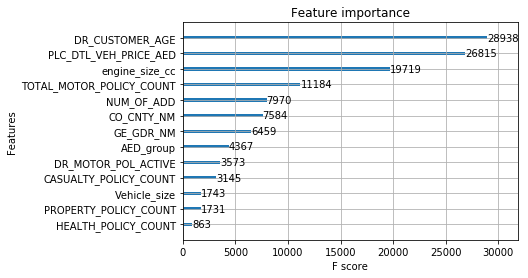

In [597]:
# plot feature importance
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(mod_bst)
pyplot.show()

From these plots we can see that Customer age is the most importance variable for the model followed by Vehicle price(AED), type of vehicle(engine size). Also Customer's policy information(TOTAL_MOTOR_POLICY_COUNT,CASUALTY_POLICY_COUNT), other demographic information(NUM_OF_ADD) and source of policy(Country name where the policy was issued) also play pivotal role in predicting customer's nationality.

- ### Further Improvement in Prediction Accuracy(For sake of time I left these options, however worth trying)

###### A)  Build predictive models using other ML techniques like RF,SVM,GBM etc and compare the performance

###### B) Model Stacking: To improve the accuracy further we can take ensemble of models approach, in which can take simple of weighted(weight defined by normal logistic regression model)scores, as final prediction scores and then find the class for which prediction score is maximum.

###### C) Segmented Modelling: We can first predict Known and Unknown(UNK) nationality first from a binary classifier and then to use a muliclass classifier to predict nationality class of Known nationality.

###### D) Also we can use vehicle related features- Vehicle makes(geographical cluster of vehicle makes), vehicle model(grouping based on makes and type of model) and other vehicle features(from PLC_DTL_VEH_VERSION)

#### Annexure1- I did some further deep dive to get an understanding unknown(UNK) nationality. These are not in the scope of the defined questions.  

In [ ]:
#Some insight about nationality Known and UNK(Unknown) in terms of vehicle price

#Nationality group
group = pd.Series([])
for i in tqdm(range(data.shape[0])):
    if data['CO_NATLY_CNTY_CODE'][i]==0:
        group[i]='UNK' 
    else:
        group[i]='Known' 
data['nation_group'] = group 
data = pd.read_csv('D:/data_science/axa_assessment/data_make_nationality_corrected_price_nat_gr.csv')

              PLC_DTL_VEH_PRICE_AED
nation_group                       
Known                 529189.891611
UNK                    79620.522148


Text(0.5,1,'Natioanlity Type')

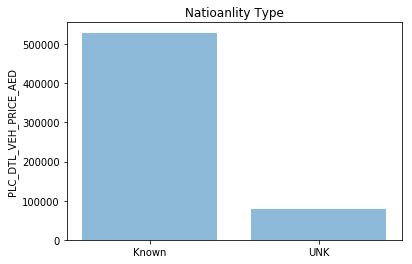

In [614]:
#Check Whether there is a difference between UNK and Known nationality in terms of vehicle price
print(data[['PLC_DTL_VEH_PRICE_AED', 'nation_group']].groupby(['nation_group']).mean())

t = data[['PLC_DTL_VEH_PRICE_AED', 'nation_group']].groupby(['nation_group']).mean()
objects = ('Known','UNK')
plt.bar(objects, t['PLC_DTL_VEH_PRICE_AED'], align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('PLC_DTL_VEH_PRICE_AED')
plt.title('Natioanlity Type')

AED_group         High       Low       Med  SuperHigh  VeryHigh
nation_group                                                   
Known         0.099962  0.078847  0.082627   0.105572  0.089862
UNK           0.100050  0.121371  0.117178   0.094439  0.110091


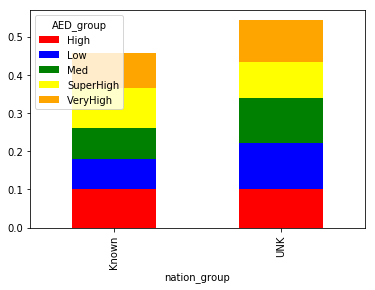

In [615]:
#Out of UNK and Known of nationality Which category buys more % of super expensive cars
#Is there a difference between UNK and Known nationality in terms of type of vehicle buy based on price
data = data.sort_values(['PLC_DTL_VEH_PRICE_AED'], ascending=True)
temp3 = pd.crosstab(data['nation_group'], data['AED_group'], normalize=True)
temp3.plot(kind='bar', stacked=True, color=['red','blue','green','yellow','orange'], grid=False)
print(temp3)

In [616]:
#There is some difference in distribution of purchased vehicle price between two broad nationality types- UNK and Known  
#For Un
#Let's do Chi-Squared Test of Independence to check whether these differences is statistically significant or not
cross_tab = pd.crosstab(data['nation_group'], data['AED_group'], margins=True)
observed = cross_tab.ix[0:2,0:5]
print(observed)
expected =  np.outer(cross_tab["All"][0:2],
                     cross_tab.ix["All"][0:5]) / 33863

expected = pd.DataFrame(expected)
expected.columns = ['High','Low','Med','SuperHigh','VeryHigh']
expected.index = ['Known','UNK']
print(expected)
from scipy.stats import chi2
chi_squared_stat  = (((observed-expected)**2)/expected).sum().sum()
print('chi_squared_stat')
print(chi_squared_stat)
crit = chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 4)   # df = (row-1)*(column-1)
print("Critical value")
print(crit)

p_value = 1 - chi2.cdf(x=chi_squared_stat,  # Find the p-value
                             df=4)
print("P value")
print(p_value)

C:\Users\Sourish\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



AED_group     High   Low   Med  SuperHigh  VeryHigh
nation_group                                       
Known         3385  2670  2798       3575      3043
UNK           3388  4110  3968       3198      3728


C:\Users\Sourish\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



              High         Low          Med    SuperHigh     VeryHigh
Known  3094.382748  3097.58084  3091.184656  3094.382748  3093.469007
UNK    3678.617252  3682.41916  3674.815344  3678.617252  3677.530993
chi_squared_stat
349.080186799536
Critical value
9.487729036781154
P value
0.0
